<div align="center">

# MEGR7172/8172

### Computational Methods (Fall 2025)
### Duke 227, Tu/Th 08:30 - 09:45 pm

</div>


# 12 2D problems

Let's continue our journey in optimization. If we extend the gradient descent algorithm to two-variables system. How shall we implements it.

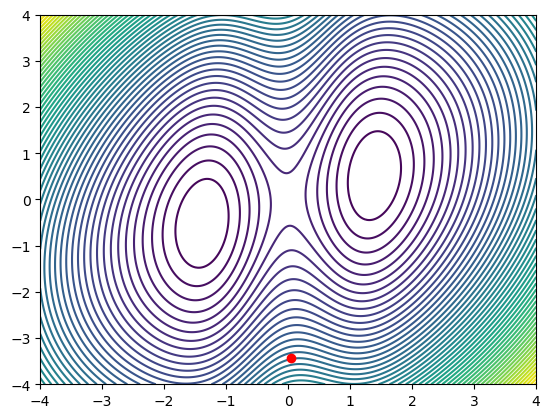

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x): #simple function with 1 minimum
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 # + 3* np.exp(-x[0]**2)

def f2(x): #complex function with 2 minimum
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 + 3* np.exp(-x[0]**2)
    #return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

def init(x_min, x_max, y_min, y_max):
    x0 = x_min+np.random.random()*(x_max-x_min)
    y0 = y_min+np.random.random()*(y_max-y_min)
    return [x0, y0]

x_min, x_max = -4, 4
y_min, y_max = -4, 4                   

nx = np.linspace(x_min,x_max,400)
ny = np.linspace(y_min,y_max,400)

x,y = np.meshgrid(nx,ny)
z = f2([x, y])
fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.3)
plt.contour(x,y,z, levels=levels)

x0, y0 = init(x_min, x_max, y_min, y_max)
plt.plot(x0, y0, 'ro')
plt.show()


## 12.1 Gradient descent with variable step size

We will start with the gradient descent method and variable step size as we implemented in the previous lecture.

In [14]:
def derivative2(f, x, h=1e-6):
    """
    f: function
    x: 1*2 array
    h: step size
    """
    x = np.asarray(x, dtype=float)
    h_vec = np.eye(x.size) * h
    f_x1 = np.array([f(x + h_vec[i]) for i in range(x.size)])
    f_x2 = np.array([f(x - h_vec[i]) for i in range(x.size)])
    df = (f_x1 - f_x2) / (2 * h)
    return df

def minimize(f,x0, N=1000):
    """
    x0: 1*2 array
    """
    
    x_now = x0
    x_prev = None
    converged = False
    x_hist = []
    x_hist.append(x_now)
    for i in range(N):
        
        df_now = derivative2(f2, x_now) 
        
        if x_prev is None:
            dx = 0.01
        else:
            df_prev = derivative2(f2, x_prev)
            dd = df_now - df_prev
            dx = np.dot(x_now - x_prev, dd) / (np.linalg.norm(dd))**2
        x_next = x_now - df_now*dx

        if f(x_next) > f(x_now):
            converged = True
            break
        else:
            x_prev = x_now
            x_now = x_next
            x_hist.append(x_now)

    return converged, np.array(x_hist), f(x_now)

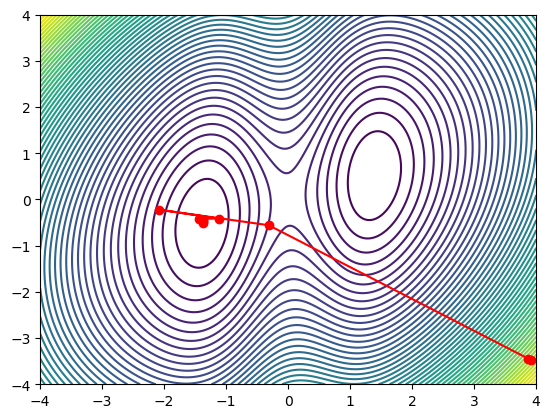

f_min:   1.309623 with  10 iterations
[ 3.91762332 -3.47731742] 15.110170640987421
[-1.37408437 -0.51560232] 1.309622693692534


In [15]:
[x0, y0] = init(x_min, x_max, y_min, y_max)
converged, x_hist, f_min = minimize(f2, [x0,y0])
x,y = np.meshgrid(nx,ny)
z = f2([x, y])
fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.3)
plt.contour(x,y,z, levels=levels)

plt.plot(x_hist[:,0], x_hist[:,1], 'ro-')
plt.show()
print(f'f_min: {f_min:10.6f} with {len(x_hist):3d} iterations')
print(x_hist[0], f2(x_hist[0]))
print(x_hist[-1], f2(x_hist[-1]))

## 12.2 Conjungate Gradient
As you have seen in the gradient descent method the algorihtm makes steps in same direction several times. 
$$ d_0 = \gamma \nabla f(x_0)$$

Here’s an idea: let’s pick a set of orthoginal search directions so that if we take exactly one step of right length in each of those directions we will reach the minimum. In order to rectify this, we require that our directions be conjugate to one another.

$$ d_1 = \nabla f(x_1) + \beta_0d_0$$

See more details in [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_gradient_method)


CG minimum: 1.309622 at [-1.37484527 -0.51556673]


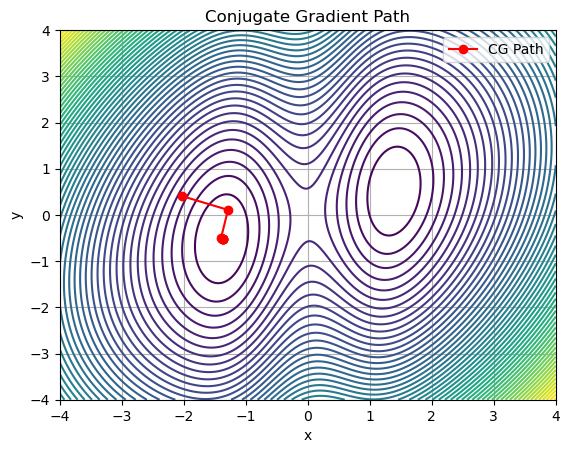

In [20]:
from scipy.optimize import minimize_scalar

def conjugate_gradient(f, grad_f, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    r = -grad_f(f, x)
    d = r.copy()
    x_hist = [x.copy()]
    for i in range(max_iter):
        alpha_num = np.dot(r, r)
        # Line search for optimal step size
        def phi(alpha):
            return f(x + alpha * d)
        res = minimize_scalar(phi)
        alpha = res.x if res.success else 0.01

        x_new = x + alpha * d
        r_new = -grad_f(f, x_new)
        beta = np.dot(r_new, r_new) / (alpha_num + 1e-12)
        d = r_new + beta * d

        x_hist.append(x_new.copy())
        if np.linalg.norm(r_new) < tol:
            break
        x = x_new
        r = r_new
    return np.array(x_hist), f(x_new)

# Run CG minimization
x_hist_cg, f_min_cg = conjugate_gradient(f2, derivative2, [x0, y0])
print(f'CG minimum: {f_min_cg:.6f} at {x_hist_cg[-1]}')

# Plot CG path on contour
plt.contour(x, y, z, levels=levels)
plt.plot(x_hist_cg[:, 0], x_hist_cg[:, 1], marker='o', color='red', label='CG Path')
plt.title('Conjugate Gradient Path')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


## 12.3 Minimization Packages in Scipy

In [17]:
from scipy.optimize import minimize

[x0, y0] = init(x_min, x_max, y_min, y_max)
res = minimize(f2, [x0,y0], method='nelder-mead', tol=1e-4, options={'disp': True})
res = minimize(f2, [x0,y0], method='CG', tol=1e-4, options={'disp': True})
res = minimize(f2, [x0,y0], method='BFGS', tol=1e-4, options={'disp': True})
res = minimize(f2, [x0,y0], method='powell', tol=1e-4, options={'disp': True})

Optimization terminated successfully.
         Current function value: 1.309622
         Iterations: 43
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 1.309622
         Iterations: 7
         Function evaluations: 45
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 1.309622
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.309622
         Iterations: 3
         Function evaluations: 83
